In [1]:
#scrape data from wiki page
from bs4 import BeautifulSoup
import requests
import pandas as pd

df = pd.DataFrame(columns=['Postcode', 'Borough', 'Neighbourhood'])

with open('wikipage.htm') as html_file:
    soup = BeautifulSoup(html_file,'lxml')

i=0    
for code in soup.find('div',class_='mw-parser-output').table.tbody.find_all('tr'):
    list0=list()
    for element in code.find_all('td'):
        list0.append(element.text.strip())
    if list0==list():continue
    df.loc[i]=list0
    i=i+1

pd.options.mode.chained_assignment = None

#get rid of the ones with no assigned borough
df_bo=df[df['Borough']!='Not assigned']


#deal with no neighbourhood
index=(df_bo['Neighbourhood']=='Not assigned')
index
df_bo.loc[index,'Neighbourhood']=df_bo.loc[index,'Borough']




#combine the ones with same postcode
df_nei=df_bo.groupby(['Postcode','Borough']).Neighbourhood.apply(lambda x : ",".join(x)).to_frame()

#final data
df_canada=df_nei.reset_index()

data = pd.read_csv("Geospatial_Coordinates.csv") 
data.rename(columns={'Postal Code':'Postcode'}, inplace=True)

df_merge =pd.merge(df_canada,data,how='left',on='Postcode')
df_merge.head()


,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [2]:
df_merge['Borough'].unique()

array(['Scarborough', 'North York', 'East York', 'East Toronto',
       'Central Toronto', 'Downtown Toronto', 'York', 'West Toronto',
       "Queen's Park", 'Mississauga', 'Etobicoke'], dtype=object)

In [3]:
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 


!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library




Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.



In [6]:
#foursquare api
import random

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 

# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#Define Foursquare Credentials and Version
CLIENT_ID = '2USAT4JF3HVHMVFO4IRPNZHPUHNVYEM2BC3LY1OUHMZYNZPU' # your Foursquare ID
CLIENT_SECRET = 'VTKBIKZJDYXLRZZEYGWT54KNDB1K3MUBN5EKTAOQ5LEV0OWJ' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

In [7]:
address = 'Toronto,Canada'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))
LIMIT = 100
radius = 500

The geograpical coordinate of Toronto are 43.653963, -79.387207.


In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
# get nearby venues
df_toronto=df_merge[df_merge["Borough"].isin(
    ["East Toronto","Central Toronto","Downtown Toronto","West Toronto"])]
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude'])

The Beaches
The Danforth West,Riverdale
The Beaches West,India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park,Summerhill East
Deer Park,Forest Hill SE,Rathnelly,South Hill,Summerhill West
Rosedale
Cabbagetown,St. James Town
Church and Wellesley
Harbourfront,Regent Park
Ryerson,Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide,King,Richmond
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Commerce Court,Victoria Hotel
Roselawn
Forest Hill North,Forest Hill West
The Annex,North Midtown,Yorkville
Harbord,University of Toronto
Chinatown,Grange Park,Kensington Market
CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place,Underground city
Christie
Dovercourt Village,Dufferin
Little Portugal,Trinity
Brockton,Exhibition Place,Parkdale Village
High Park,The Junction South
Parkdale,Roncesvall

In [12]:
print(toronto_venues.shape)

(1689, 7)


In [13]:
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West,Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant


In [14]:
toronto_venues.groupby("Neighbourhood").count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide,King,Richmond",100,100,100,100,100,100
Berczy Park,59,59,59,59,59,59
"Brockton,Exhibition Place,Parkdale Village",22,22,22,22,22,22
Business Reply Mail Processing Centre 969 Eastern,18,18,18,18,18,18
"CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara",14,14,14,14,14,14
"Cabbagetown,St. James Town",42,42,42,42,42,42
Central Bay Street,84,84,84,84,84,84
"Chinatown,Grange Park,Kensington Market",95,95,95,95,95,95
Christie,16,16,16,16,16,16


In [15]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 233 uniques categories.


In [16]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

#toronto_onehot["Neighborhood"]

# add neighborhood column back to dataframe
toronto_onehot = pd.concat([toronto_venues['Neighbourhood'], toronto_onehot], axis=1)

toronto_onehot

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,The Beaches,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,The Beaches,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"The Danforth West,Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"The Danforth West,Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"The Danforth West,Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"The Danforth West,Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"The Danforth West,Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,"The Danforth West,Riverdale",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Adelaide,King,Richmond",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,...,0.000000,0.000000,0.00,0.020000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
1,Berczy Park,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.016949,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Brockton,Exhibition Place,Parkdale Village",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Business Reply Mail Processing Centre 969 Eastern,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",0.000000,0.071429,0.071429,0.071429,0.142857,0.142857,0.071429,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Cabbagetown,St. James Town",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Central Bay Street,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011905,0.000000,...,0.000000,0.000000,0.00,0.011905,0.000000,0.000000,0.011905,0.000000,0.000000,0.011905
7,"Chinatown,Grange Park,Kensington Market",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.031579,0.000000,0.052632,0.010526,0.000000,0.000000,0.000000
8,Christie,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Church and Wellesley,0.011364,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011364,0.000000,...,0.000000,0.000000,0.00,0.000000,0.000000,0.011364,0.000000,0.011364,0.011364,0.011364


In [18]:
#print each neighborhood along with the top 5 most common venues
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
             venue  freq
0      Coffee Shop  0.07
1             Café  0.05
2       Steakhouse  0.04
3              Bar  0.04
4  Thai Restaurant  0.04


----Berczy Park----
                venue  freq
0         Coffee Shop  0.08
1              Bakery  0.05
2        Cocktail Bar  0.03
3  Seafood Restaurant  0.03
4            Beer Bar  0.03


----Brockton,Exhibition Place,Parkdale Village----
            venue  freq
0  Breakfast Spot  0.09
1            Café  0.09
2     Coffee Shop  0.09
3   Grocery Store  0.05
4         Stadium  0.05


----Business Reply Mail Processing Centre 969 Eastern----
                  venue  freq
0    Light Rail Station  0.11
1           Yoga Studio  0.06
2                   Spa  0.06
3  Gym / Fitness Center  0.06
4         Garden Center  0.06


----CN Tower,Bathurst Quay,Island airport,Harbourfront West,King and Spadina,Railway Lands,South Niagara----
             venue  freq
0   Airport Lounge  0.14
1  Airport Service  0.14
2     

In [47]:
# put that into a pandas dataframe
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
# display the top 10 venues for each neighborhood.
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
import numpy as np
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide,King,Richmond",Coffee Shop,Café,Bar,Steakhouse,Thai Restaurant,Burger Joint,Cosmetics Shop,Hotel,Bakery,Breakfast Spot
1,Berczy Park,Coffee Shop,Bakery,Cheese Shop,Farmers Market,Steakhouse,Cocktail Bar,Beer Bar,Seafood Restaurant,Café,Jazz Club
2,"Brockton,Exhibition Place,Parkdale Village",Breakfast Spot,Café,Coffee Shop,Pet Store,Bakery,Stadium,Burrito Place,Restaurant,Climbing Gym,Grocery Store
3,Business Reply Mail Processing Centre 969 Eastern,Light Rail Station,Yoga Studio,Spa,Garden Center,Garden,Fast Food Restaurant,Farmers Market,Comic Shop,Park,Pizza Place
4,"CN Tower,Bathurst Quay,Island airport,Harbourf...",Airport Lounge,Airport Service,Bar,Harbor / Marina,Airport,Airport Food Court,Airport Gate,Airport Terminal,Boat or Ferry,Plane


In [48]:
#cluster neighbourhood
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_toronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged # check the last columns!

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,1,Health Food Store,Trail,Pub,Neighborhood,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
41,M4K,East Toronto,"The Danforth West,Riverdale",43.679557,-79.352188,1,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Restaurant,Yoga Studio,Brewery,Bubble Tea Shop,Pub
42,M4L,East Toronto,"The Beaches West,India Bazaar",43.668999,-79.315572,1,Sandwich Place,Coffee Shop,Ice Cream Shop,Burger Joint,Liquor Store,Burrito Place,Fast Food Restaurant,Fish & Chips Shop,Steakhouse,Italian Restaurant
43,M4M,East Toronto,Studio District,43.659526,-79.340923,1,Café,Coffee Shop,Bakery,Italian Restaurant,American Restaurant,Sandwich Place,Fish Market,Bookstore,Coworking Space,Latin American Restaurant
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,3,Photography Studio,Park,Lawyer,Bus Line,Swim School,Yoga Studio,Diner,Event Space,Ethiopian Restaurant,Electronics Store
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197,1,Food & Drink Shop,Gym,Park,Breakfast Spot,Sandwich Place,Clothing Store,Hotel,Yoga Studio,Dog Run,Doner Restaurant
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,1,Coffee Shop,Sporting Goods Shop,Clothing Store,Yoga Studio,Diner,Dessert Shop,Mexican Restaurant,Salon / Barbershop,Metro Station,Ice Cream Shop
47,M4S,Central Toronto,Davisville,43.704324,-79.388790,1,Pizza Place,Sandwich Place,Dessert Shop,Gym,Coffee Shop,Italian Restaurant,Café,Sushi Restaurant,Greek Restaurant,Fried Chicken Joint
48,M4T,Central Toronto,"Moore Park,Summerhill East",43.689574,-79.383160,0,Gym,Trail,Restaurant,Yoga Studio,Dessert Shop,Event Space,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
49,M4V,Central Toronto,"Deer Park,Forest Hill SE,Rathnelly,South Hill,...",43.686412,-79.400049,1,Pub,Coffee Shop,Pizza Place,Sports Bar,Restaurant,Supermarket,Sushi Restaurant,Bagel Shop,Liquor Store,Fried Chicken Joint


In [49]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

the map
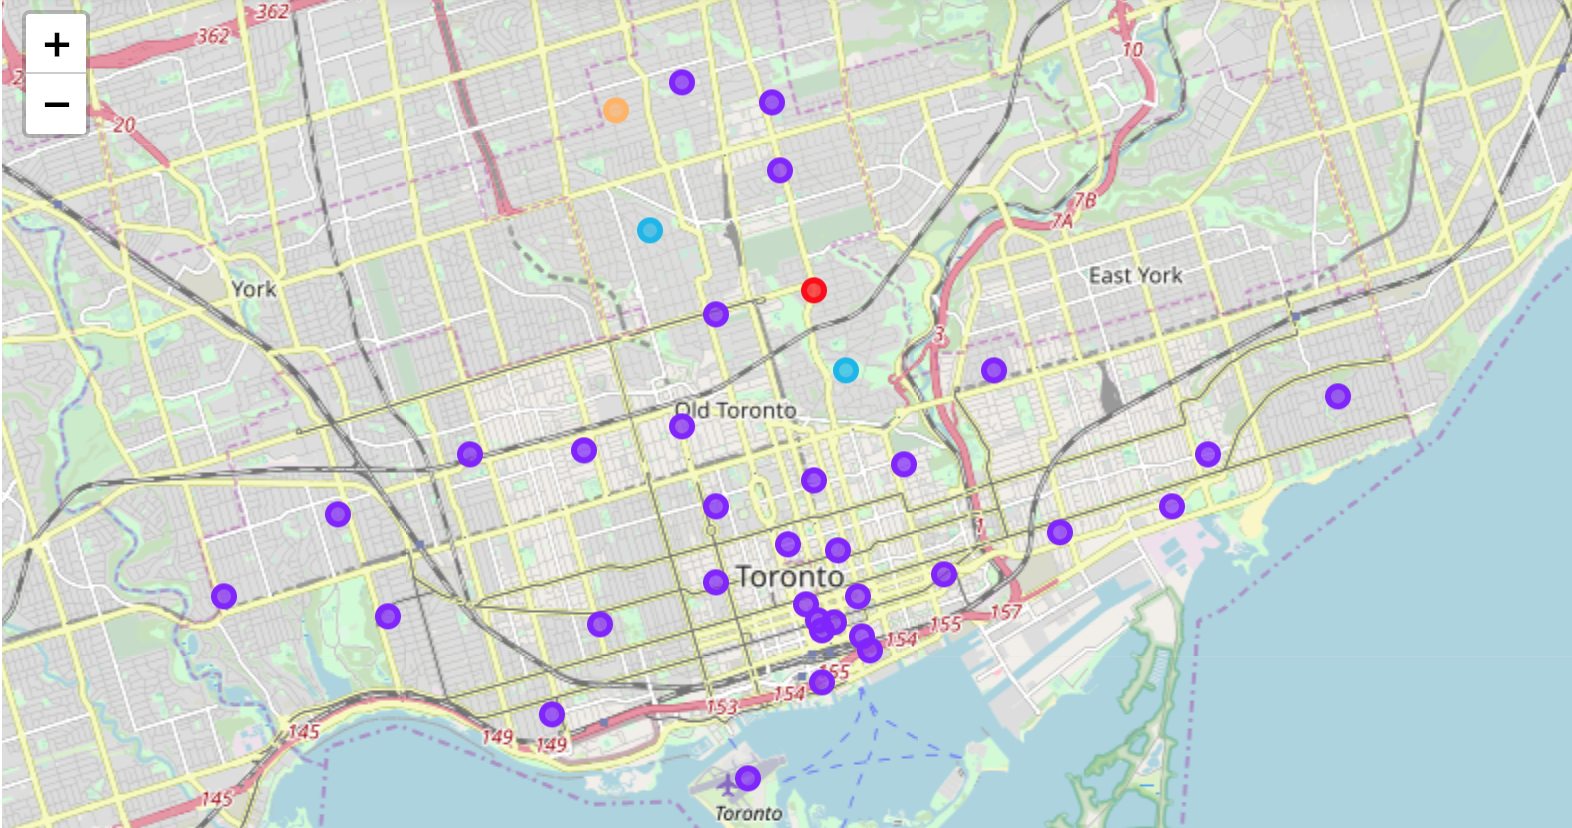